In [1]:
import os
seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
experiment = 'Variation 7 LSTM Experiments results - 600779.SS'

In [2]:
import requests
import lxml
import datetime as dt
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.utils import compute_class_weight
import tensorflow as tf
from pil import Image
from sklearn import preprocessing
import tensorflow_addons as tfa

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
# gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.333)
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
np.random.seed(seed)
tf.random.set_seed(seed)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

## Sichuan Swellfun Co.,Ltd (Small Cap)

### Test Performance

### non-recession

In [5]:
column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
log  = pd.DataFrame(columns = column_names)
logger = []

In [6]:
seed = 10
df = pd.read_csv("data/variation 7/initial_indicators/600779.SS_data_test.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2019-01-22    31.600000  30.182096 -19.458106  26955841.0     2.0
2019-01-23    30.840000  30.283312 -37.717127  23083639.0     2.0
2019-01-24    30.780001  30.359725 -39.205947  19954758.0     2.0
2019-01-25    31.190001  30.487460 -32.142848  23689151.0     2.0
2019-01-28    30.440001  30.480159 -52.747236  18093372.0     2.0


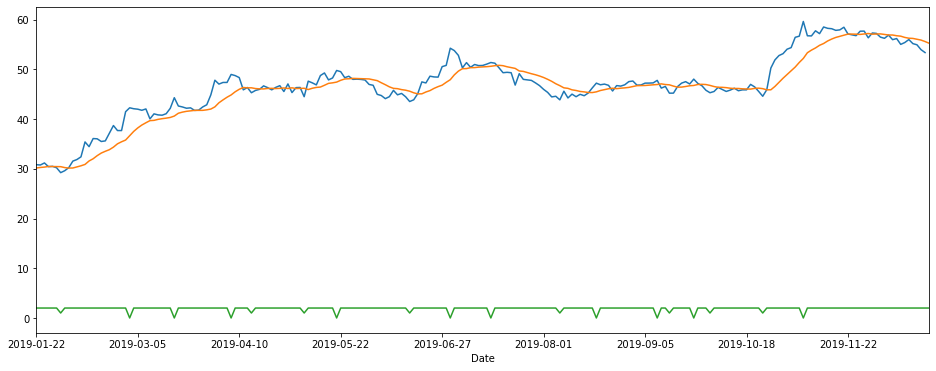

In [7]:
#%matplotlib notebook
df['previous_1d'].shift(-1).plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [8]:
# willr_data = []
# price_data = []
# ema_data = []
# obv_data = []
# labels = []
# data_15_price = []
# data_15_willr = []
# data_15_ema = []
# data_15_obv = []
# count = 0

# for i in df.values:
#     if count == 14:
#         data_15_price.append([i[0]])
#         data_15_ema.append([i[1]])
#         data_15_willr.append([i[2]])
#         data_15_obv.append([i[3]])
#         price_data.append(data_15_price)
#         willr_data.append(data_15_willr)
#         ema_data.append(data_15_ema)
#         obv_data.append(data_15_obv)
#         labels.append(i[-1])
#         data_15_price = data_15_price[1:]
#         data_15_willr = data_15_willr[1:]
#         data_15_obv = data_15_obv[1:]
#         data_15_ema = data_15_ema[1:]
    
#     else:
#         data_15_price.append([i[0]])
#         data_15_ema.append([i[1]])
#         data_15_willr.append([i[2]])
#         data_15_obv.append([i[3]])
#         count += 1

In [9]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [10]:
X = sequential
X  = np.array(X).reshape(-1, 15, 4)
y = labels
y = np.array(y)
X.shape

(207, 15, 4)

In [11]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [12]:
model = tf.keras.models.load_model("models/600779.SS_time_series_lstm_buy_hold_sell.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

7/7 [==============================] - 0s 3ms/step - loss: 0.1768 - accuracy: 0.7343 - mean_squared_error: 6.8659 - weighted_accuracy: 0.7343 - weighted_mean_squared_error: 6.8659
Test loss: 0.1768196076154709
Test accuracy: 0.7342995405197144


In [13]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({0: 26, 2: 160, 1: 21})

In [14]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 190, 0: 10, 1: 7})

In [15]:
df = pd.read_csv("data/variation 7/initial_indicators/600779.SS_data_test.csv")
df.set_index('Date', inplace=True)

In [16]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-18,36.099998,32.034229,-17.894717,52087886.0,2.0,0,2
2019-02-19,36.049999,32.659732,-4.318486,60953594.0,2.0,0,2
2019-02-20,35.509998,33.181312,-9.395105,54650369.0,2.0,0,2
2019-02-21,35.630001,33.539571,-16.344925,49659599.0,2.0,2,2
2019-02-22,37.189999,33.861176,-14.800488,55796926.0,2.0,2,2


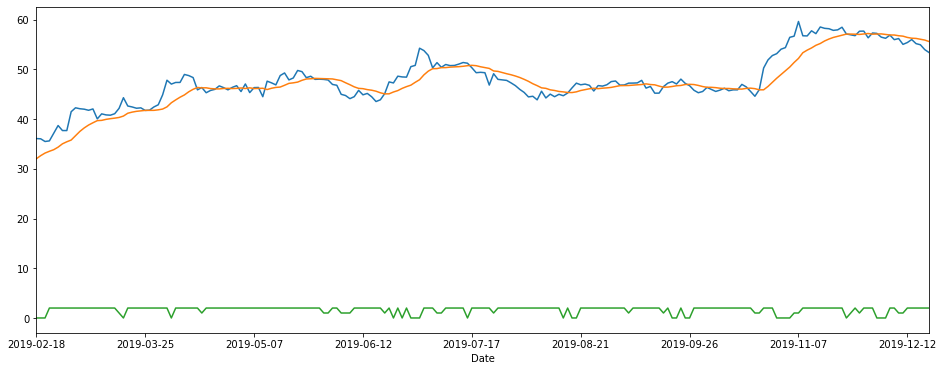

In [17]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['predictions'].plot(figsize=(16,6),x='Date', y='predictions')
#df['actual'].plot(figsize=(16,6),x='Date', y='actual')

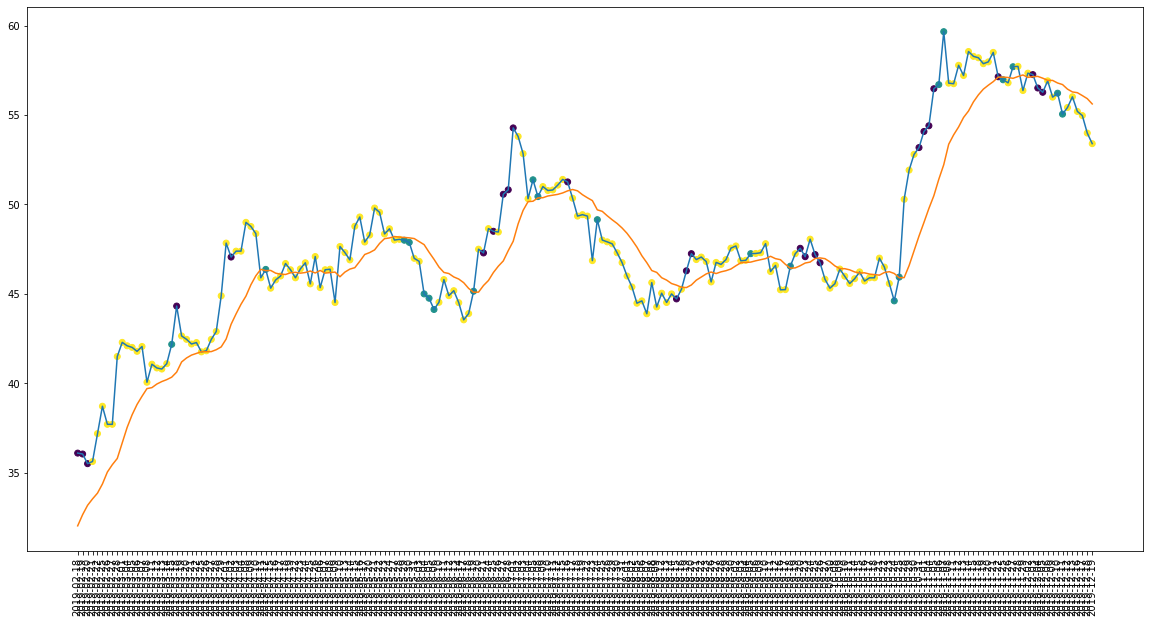

In [18]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

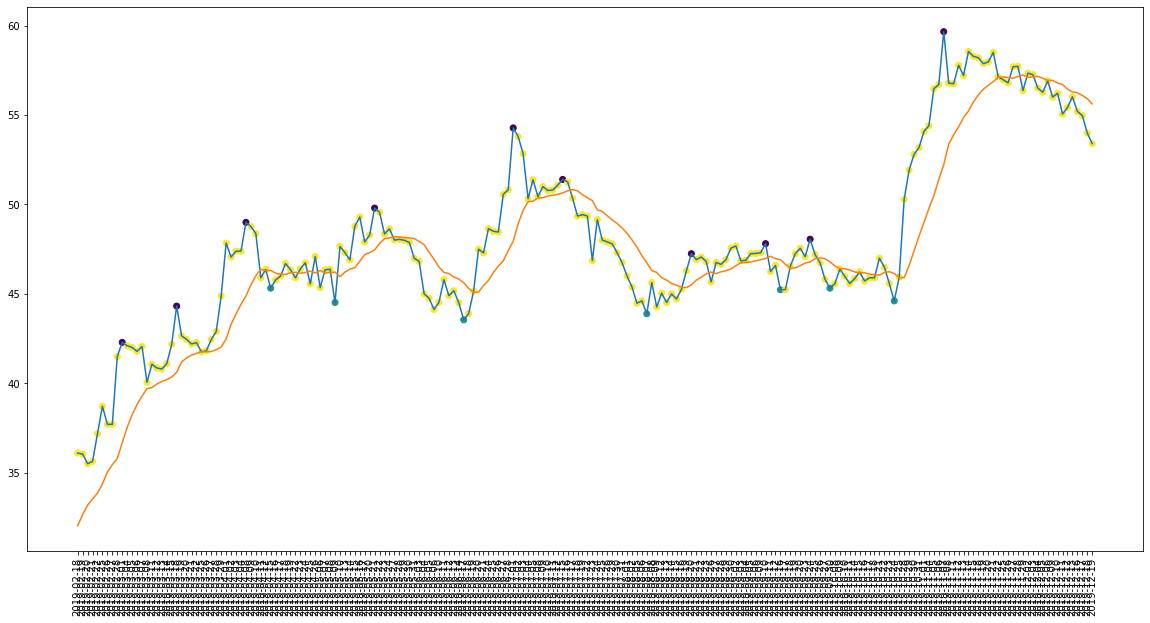

In [19]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [20]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 207
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 1
actual predicted sells: 3
actual sells but predicted hold: 6
actual holds but predicted buy: 19
actual holds but predicted sell: 23
actual predicted holds: 148
Percentage buys correct: 14.285714285714286%
Percentage sells correct: 30.0%
Percentage holds correct: 77.89473684210526%
actual buys: 7
actual sells: 10
actual holds: 190


In [21]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%") ; logger.append(str(100*correct_minima/buy) + "%") ; logger.append(str(100*correct_maxima/sell) + "%") ; logger.append(str(100*correct_hold/hold) + "%")

[35.5099983215332, 35.630001068115234, 36.04999923706055, 36.099998474121094, 37.18999862670898, 37.709999084472656, 37.709999084472656, 38.72000122070313, 41.5]
[37.709999084472656, 37.709999084472656, 40.060001373291016, 41.5, 41.790000915527344, 42.0099983215332, 42.060001373291016, 42.099998474121094, 42.290000915527344]
Percentage buys correct: 52.38095238095238%
Percentage sells correct: 30.76923076923077%
Percentage holds correct: 83.01886792452831%


In [22]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $42.18000030517578
Shares owned at the moment: 236
Cash capital at the moment: $18.145107780455874


Price increase from previously bought: 11.263492046488155%
Share price: $47.06000137329102
Shares owned at the moment: 0
Cash capital at the moment: $11093.763490985872


Share price: $46.36999893188477
Shares owned at the moment: 238
Cash capital at the moment: $27.35458089637723


Stop Loss Activated!

Share price: $44.52000045776367
Shares owned at the moment: 0
Cash capital at the moment: $10593.976349544524


Share price: $48.0
Shares owned at the moment: 220
Cash capital at the moment: $4.936349544523182


Stop Loss Activated!

Share price: $45.0
Shares owned at the moment: 0
Cash capital at the moment: $9877.711349544523


Share price: $45.0
Shares owned at the moment: 218
Cash capital at the moment: $40.733849544521945


Stop Loss Activated!

Share price: $43.54999923706055
Shares owned at the moment: 0
Cash capital at the moment: $9508.525458681102


Share price: $

In [23]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $14706.870342285152
profit gained: 47.06870342285152%


In [24]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.7343,14.285714285714286%,30.0%,77.89473684210526%,52.38095238095238%,30.76923076923077%,83.01886792452831%,-5.942615165119223%,47.06870342285152%


### Recession

In [25]:
logger = []

In [26]:
seed = 10
df = pd.read_csv("data/variation 7/initial_indicators/600779.SS_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12    willr_14       OBV_7  labels
Date                                                              
2020-01-22    49.880001  51.521484  -90.954757   9556447.0     2.0
2020-01-23    50.939999  51.432025  -47.232514  14604083.0     2.0
2020-02-03    51.389999  51.425560  -43.127187  25428297.0     2.0
2020-02-04    46.250000  50.629320 -100.000000  24157097.0     1.0
2020-02-05    44.200001  49.640194  -88.990820  13715132.0     2.0


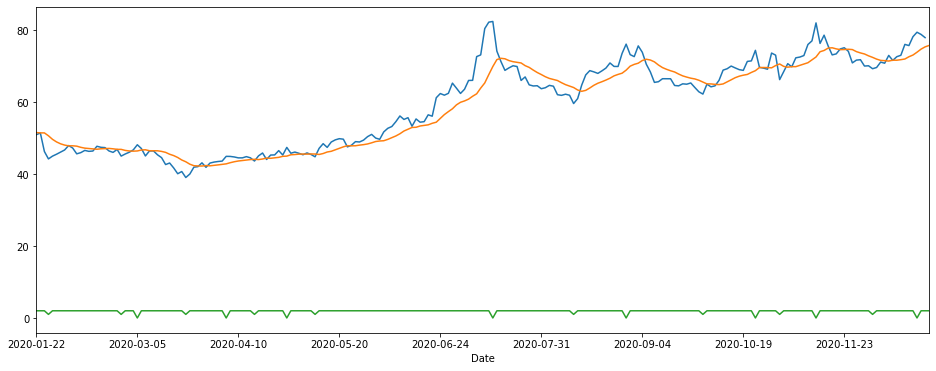

In [27]:
#%matplotlib notebook
df['previous_1d'].shift(-1).plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [28]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [29]:
X = sequential
X  = np.array(X).reshape(-1, 15, 4)
y = labels
y = np.array(y)
X.shape

(208, 15, 4)

In [30]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [31]:
model = tf.keras.models.load_model("models/600779.SS_time_series_lstm_buy_hold_sell.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

7/7 [==============================] - 0s 3ms/step - loss: 0.1575 - accuracy: 0.7212 - mean_squared_error: 7.9123 - weighted_accuracy: 0.7212 - weighted_mean_squared_error: 7.9123
Test loss: 0.15750756859779358
Test accuracy: 0.7211538553237915


In [32]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 162, 1: 22, 0: 24})

In [33]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [34]:
df = pd.read_csv("data/variation 7/initial_indicators/600779.SS_data_test2.csv")
df.set_index('Date', inplace=True)

In [35]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-19,46.389999,46.971424,-69.724782,32887141.0,2.0,2,2
2020-02-20,47.709999,46.881974,-68.899093,37851556.0,2.0,2,2
2020-02-21,47.419998,47.009362,-13.736266,44568040.0,2.0,2,2
2020-02-24,47.340000,47.072537,-19.047639,39428841.0,2.0,2,2
2020-02-25,46.400002,47.113685,-21.747562,34329743.0,2.0,2,2


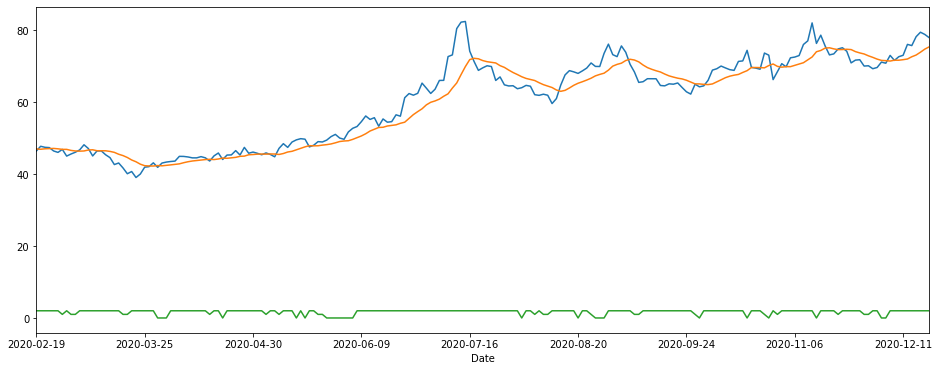

In [36]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['predictions'].plot(figsize=(16,6),x='Date', y='predictions')
#df['actual'].plot(figsize=(16,6),x='Date', y='actual')

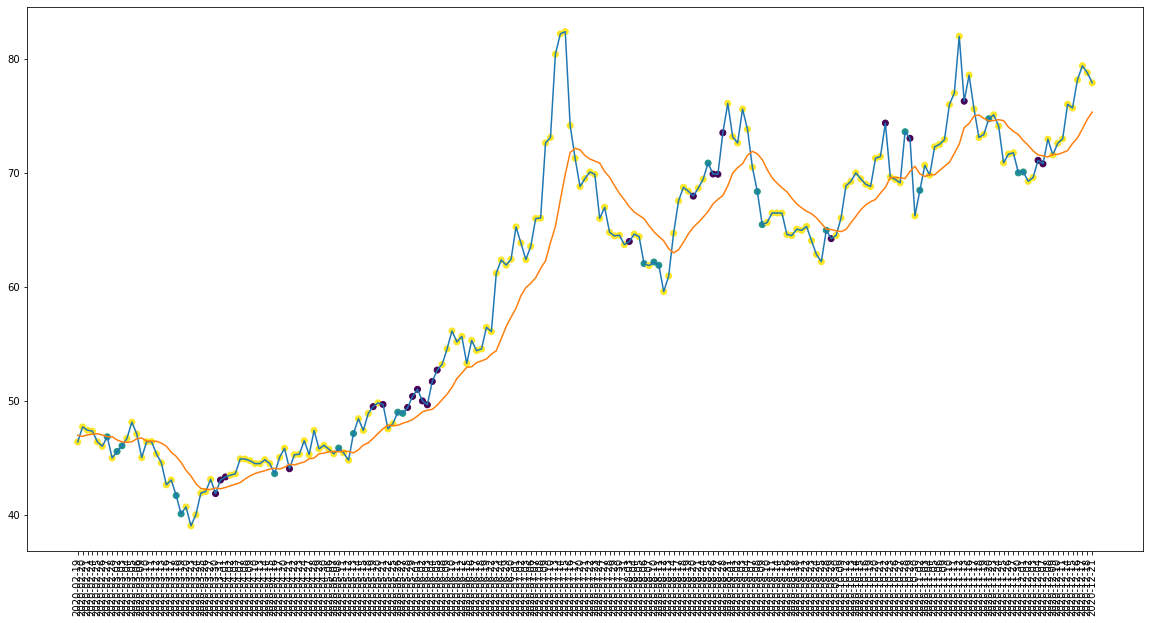

In [37]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

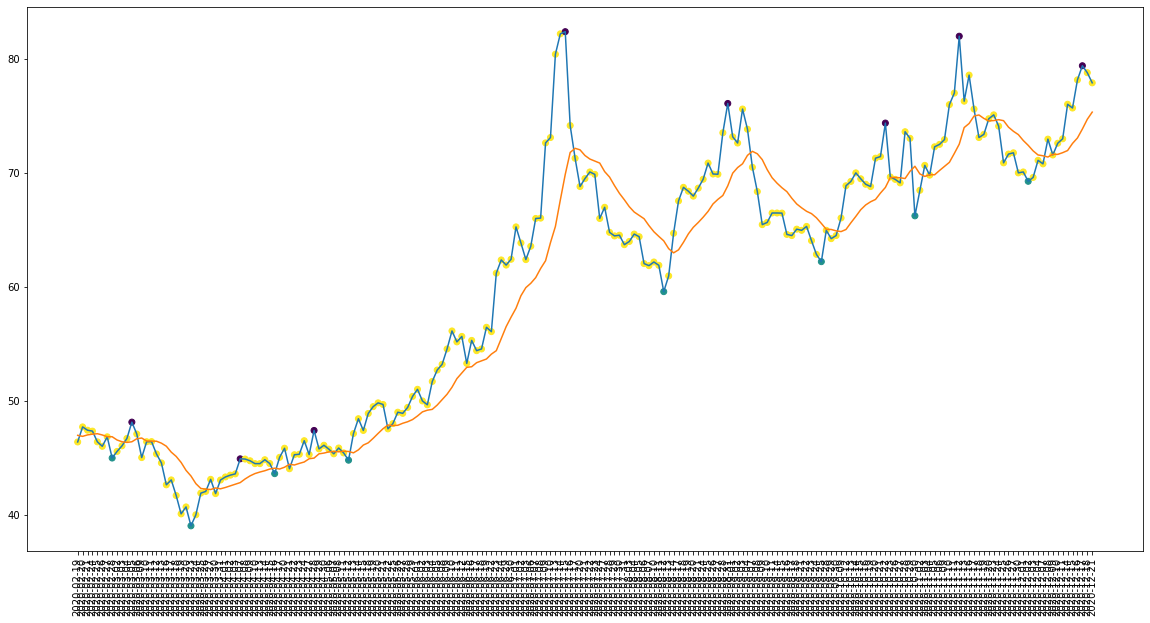

In [38]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [39]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 208
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 7
actual holds but predicted buy: 21
actual holds but predicted sell: 23
actual predicted holds: 148
Percentage buys correct: 12.5%
Percentage sells correct: 12.5%
Percentage holds correct: 77.08333333333333%
actual buys: 8
actual sells: 8
actual holds: 192


In [40]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%") ; logger.append(str(100*correct_minima/buy) + "%") ; logger.append(str(100*correct_maxima/sell) + "%") ; logger.append(str(100*correct_hold/hold) + "%")

[44.97999954223633, 45.56000137329102, 46.0099983215332, 46.38999938964844, 46.4000015258789, 46.84000015258789, 47.34000015258789, 47.41999816894531, 47.709999084472656]
[44.97999954223633, 45.02000045776367, 45.56000137329102, 46.04999923706055, 46.40999984741211, 46.70000076293945, 46.84000015258789, 47.09000015258789, 48.13000106811523]
Percentage buys correct: 50.0%
Percentage sells correct: 37.5%
Percentage holds correct: 85.09316770186335%


In [41]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $46.84000015258789
Shares owned at the moment: 212
Cash capital at the moment: $42.61224756240881


Stop Loss Activated!

Share price: $44.97999954223633
Shares owned at the moment: 0
Cash capital at the moment: $9552.148810783387


Share price: $45.56000137329102
Shares owned at the moment: 209
Cash capital at the moment: $3.9229129762625234


Stop Loss Activated!

Share price: $42.63000106811523
Shares owned at the moment: 0
Cash capital at the moment: $8889.091543098446


Share price: $41.68999862670898
Shares owned at the moment: 212
Cash capital at the moment: $26.506565036772372


Stop Loss Activated!

Share price: $40.08000183105469
Shares owned at the moment: 0
Cash capital at the moment: $8500.100312152861


Share price: $40.08000183105469
Shares owned at the moment: 211
Cash capital at the moment: $19.963504737852418


Price increase from previously bought: 7.115604916622864%
Share price: $43.04999923706055
Shares owned at the moment: 0
Cash capital at the moment

In [42]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $16669.99579161453
profit gained: 66.69995791614528%


In [43]:
df_length = len(log)
log.loc[df_length] = logger
log.head()

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.734300,14.285714285714286%,30.0%,77.89473684210526%,52.38095238095238%,30.76923076923077%,83.01886792452831%,-5.942615165119223%,47.06870342285152%
1,0.721154,12.5%,12.5%,77.08333333333333%,50.0%,37.5%,85.09316770186335%,5.470774950237228%,66.69995791614528%


## Wuliangye Yibin Co.,Ltd.(Mid Cap)

### Test Performance

#### Non-Recession

In [44]:
logger = []

In [45]:
seed = 10
df = pd.read_csv("data/variation 7/initial_indicators/000858.SZ_data_test.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2019-01-22    56.000000  51.668614  -4.420537  97514467.0     2.0
2019-01-23    55.209999  52.213443 -13.859020  63945311.0     2.0
2019-01-24    55.070000  52.652913 -15.531654  43721083.0     2.0
2019-01-25    55.200001  53.044773 -15.620808  63080844.0     2.0
2019-01-28    55.250000  53.384039 -14.953261  87254847.0     2.0


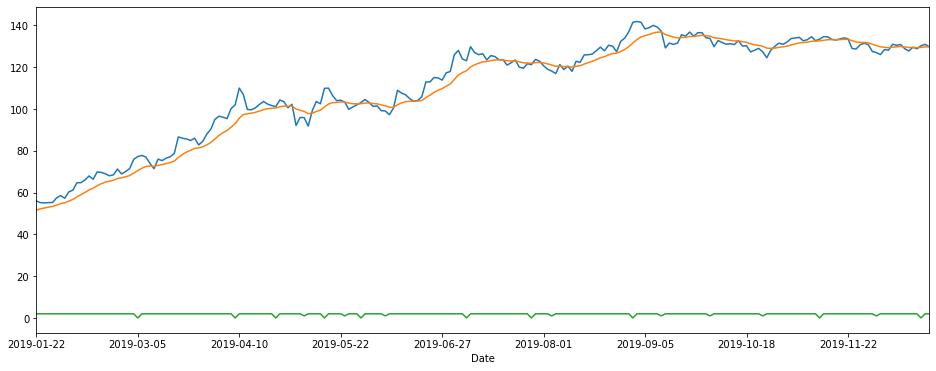

In [46]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

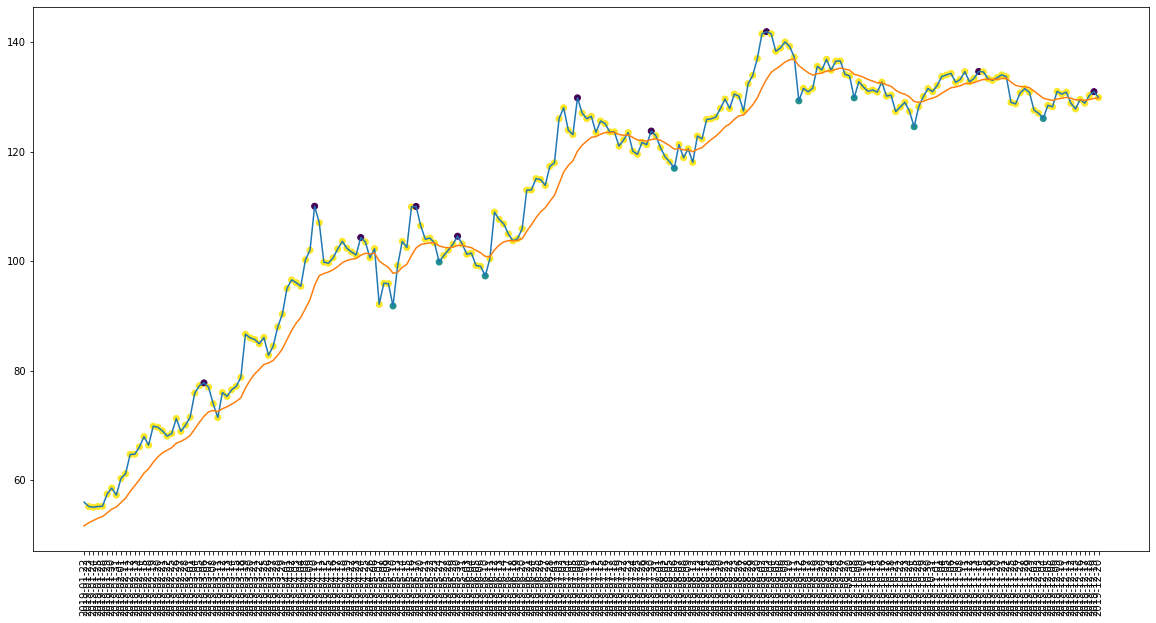

In [47]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['labels'].shift(1).values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [48]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [49]:
X = sequential
X  = np.array(X).reshape(-1, 15, 4)
y = labels
y = np.array(y)
X.shape

(207, 15, 4)

In [50]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [51]:
model = tf.keras.models.load_model("models/600779.SS_time_series_lstm_buy_hold_sell.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

7/7 [==============================] - 0s 3ms/step - loss: 0.1534 - accuracy: 0.8019 - mean_squared_error: 7.8628 - weighted_accuracy: 0.8019 - weighted_mean_squared_error: 7.8628
Test loss: 0.1533927619457245
Test accuracy: 0.8019323945045471


In [52]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 180, 0: 17, 1: 10})

In [53]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 189, 0: 10, 1: 8})

In [54]:
df = pd.read_csv("data/variation 7/initial_indicators/000858.SZ_data_test.csv")
df.set_index('Date', inplace=True)

In [55]:
# df['previous_1d'] = df['previous_1d'].shift(-1)
# df.dropna(inplace=True)
# df = df.iloc[13:]
# df['predictions'] = predictions
# df['actual'] = actual
# df.head()

In [56]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-18,69.870003,62.079834,-13.768124,379378660.0,2.0,2,2
2019-02-19,69.669998,63.278321,-0.194797,423355688.0,2.0,2,2
2019-02-20,69.010002,64.261656,-5.009411,389390836.0,2.0,0,2
2019-02-21,68.050003,64.992171,-9.327418,359762696.0,2.0,0,2
2019-02-22,68.500000,65.462607,-16.221627,331412891.0,2.0,1,2


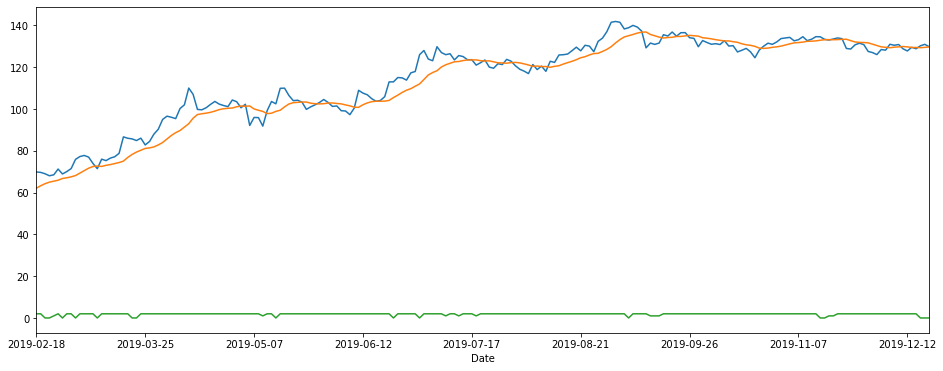

In [57]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['predictions'].plot(figsize=(16,6),x='Date', y='predictions')
#df['actual'].plot(figsize=(16,6),x='Date', y='actual')

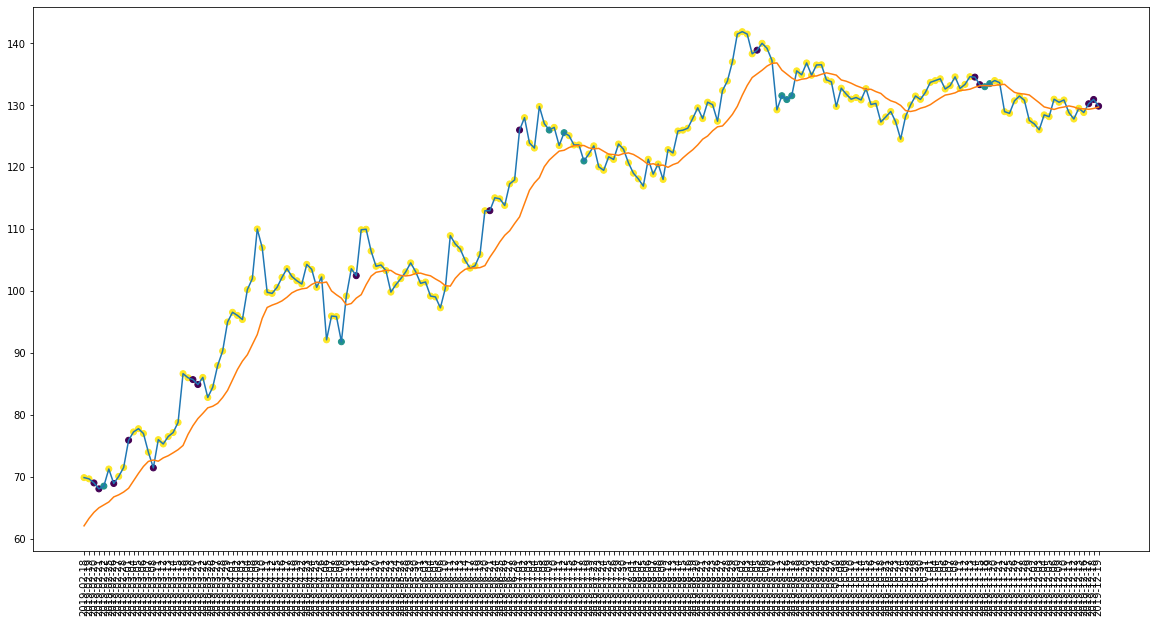

In [58]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

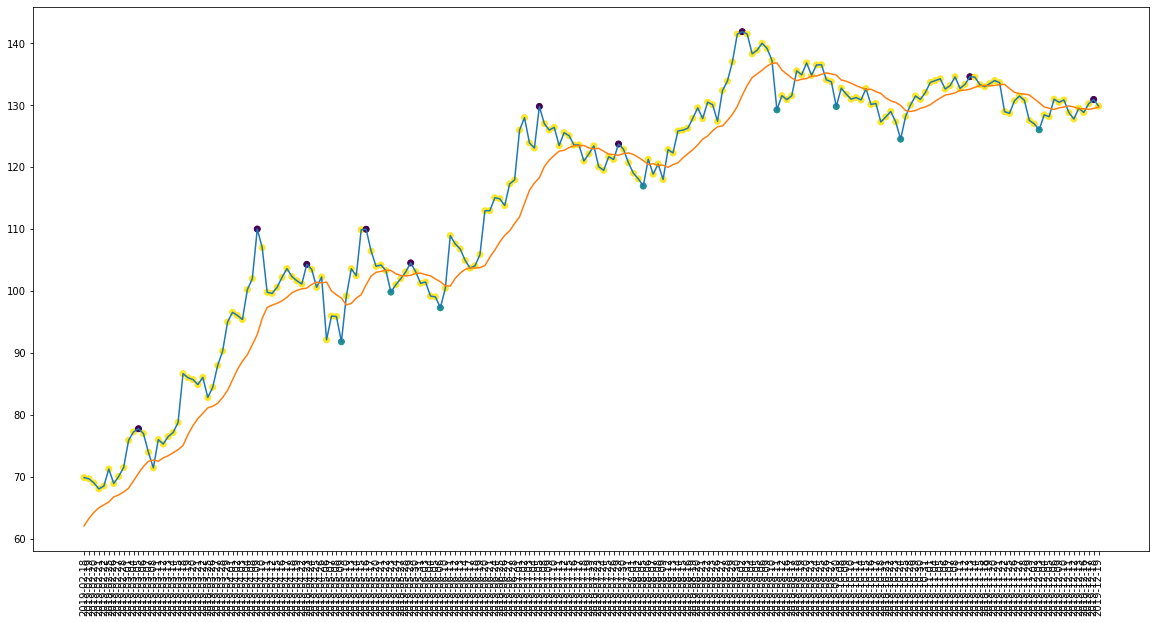

In [59]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [60]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 207
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 9
actual holds but predicted buy: 9
actual holds but predicted sell: 16
actual predicted holds: 164
Percentage buys correct: 12.5%
Percentage sells correct: 10.0%
Percentage holds correct: 86.77248677248677%
actual buys: 8
actual sells: 10
actual holds: 189


In [61]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%") ; logger.append(str(100*correct_minima/buy) + "%") ; logger.append(str(100*correct_maxima/sell) + "%") ; logger.append(str(100*correct_hold/hold) + "%")

[68.05000305175781, 68.5, 68.91999816894531, 69.01000213623047, 69.66999816894531, 69.87000274658203, 70.05999755859375, 71.26000213623047, 71.5]
[68.91999816894531, 70.05999755859375, 71.44000244140625, 71.5, 73.97000122070312, 75.9000015258789, 76.98999786376953, 77.25, 77.7699966430664]
Percentage buys correct: 70.0%
Percentage sells correct: 43.75%
Percentage holds correct: 84.44444444444444%


In [62]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $68.5
Shares owned at the moment: 145
Cash capital at the moment: $40.18562500000007


Price increase from previously bought: 10.499049549328987%
Share price: $75.9000015258789
Shares owned at the moment: 0
Cash capital at the moment: $11015.420720643997


Share price: $91.80999755859376
Shares owned at the moment: 119
Cash capital at the moment: $59.98618947028808


Price increase from previously bought: 11.315716092993489%
Share price: $102.4800033569336
Shares owned at the moment: 0
Cash capital at the moment: $12221.570007846829


Share price: $126.0
Shares owned at the moment: 96
Cash capital at the moment: $92.30600784682792


Stop Loss Activated!

Share price: $121.0
Shares owned at the moment: 0
Cash capital at the moment: $11676.362007846828


Share price: $121.0
Shares owned at the moment: 96
Cash capital at the moment: $28.418007846828914


Stop Loss Activated!

Share price: $116.9499969482422
Shares owned at the moment: 0
Cash capital at the moment: $11224.7429

In [63]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $18440.58513034439
profit gained: 84.4058513034439%


In [64]:
df_length = len(log)
log.loc[df_length] = logger
log.head()

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.734300,14.285714285714286%,30.0%,77.89473684210526%,52.38095238095238%,30.76923076923077%,83.01886792452831%,-5.942615165119223%,47.06870342285152%
1,0.721154,12.5%,12.5%,77.08333333333333%,50.0%,37.5%,85.09316770186335%,5.470774950237228%,66.69995791614528%
2,0.801932,12.5%,10.0%,86.77248677248677%,70.0%,43.75%,84.44444444444444%,4.182030078620865%,84.4058513034439%


#### Recession

In [65]:
logger = []

In [66]:
seed = 10
df = pd.read_csv("data/variation 7/initial_indicators/000858.SZ_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d      EMA_12    willr_14       OBV_7  labels
Date                                                               
2020-01-22   132.619995  134.532144  -69.037983  36658288.0     2.0
2020-01-23   131.699997  134.096429  -75.271035  10905237.0     2.0
2020-02-03   126.160004  132.875441  -93.486784 -30688431.0     1.0
2020-02-04   113.540001  129.900758 -100.000000 -47452331.0     2.0
2020-02-05   114.500000  127.531410  -83.732622  23569095.0     2.0


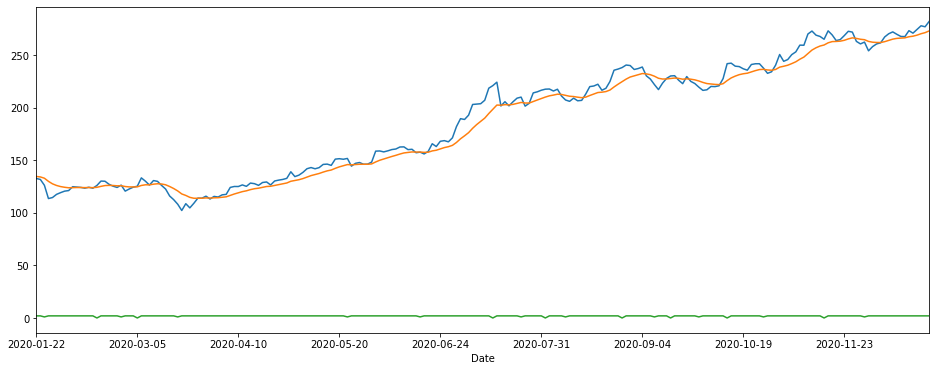

In [67]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

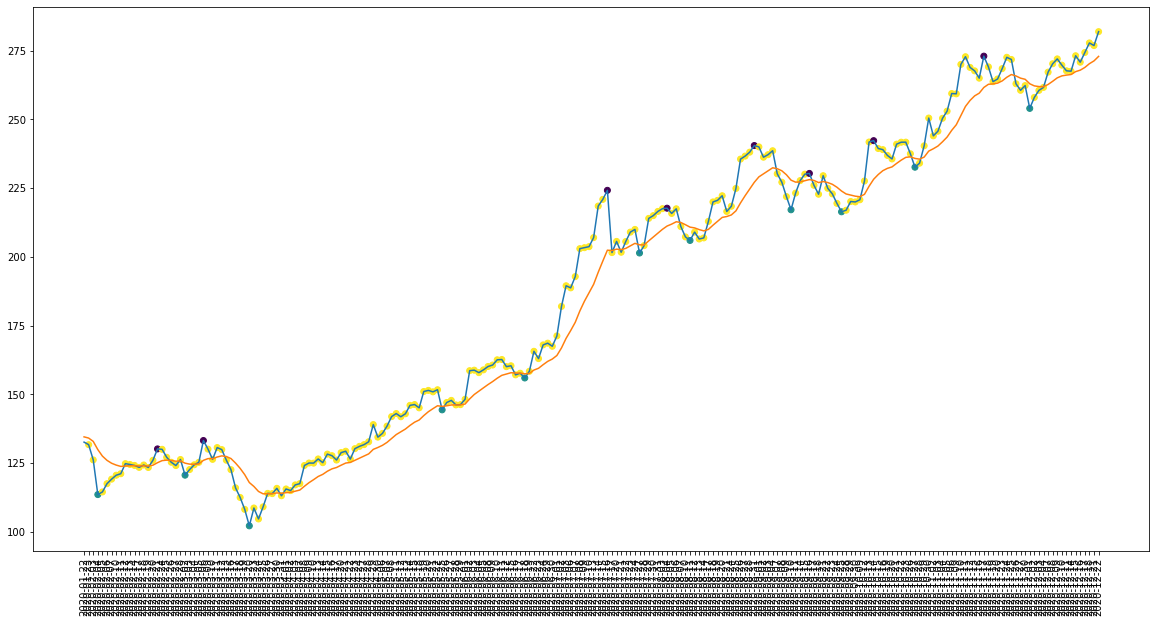

In [68]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['labels'].shift(1).values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [69]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [70]:
X = sequential
X  = np.array(X).reshape(-1, 15, 4)
y = labels
y = np.array(y)
X.shape

(208, 15, 4)

In [71]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [72]:
model = tf.keras.models.load_model("models/600779.SS_time_series_lstm_buy_hold_sell.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

7/7 [==============================] - 0s 3ms/step - loss: 0.1542 - accuracy: 0.7452 - mean_squared_error: 8.1885 - weighted_accuracy: 0.7452 - weighted_mean_squared_error: 8.1885
Test loss: 0.15422961115837097
Test accuracy: 0.745192289352417


In [73]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 160, 0: 33, 1: 15})

In [74]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 190, 0: 8, 1: 10})

In [75]:
df = pd.read_csv("data/variation 7/initial_indicators/000858.SZ_data_test2.csv")
df.set_index('Date', inplace=True)

In [76]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-19,126.000000,123.907706,-39.205744,126477180.0,2.0,2,2
2020-02-20,130.149994,124.229597,-25.340374,158139956.0,0.0,2,0
2020-02-21,130.000000,125.140427,-1.992622,191606116.0,2.0,2,2
2020-02-24,127.099998,125.888054,-5.405392,170862365.0,2.0,2,2
2020-02-25,125.300003,126.074507,-23.976601,147302241.0,2.0,2,2


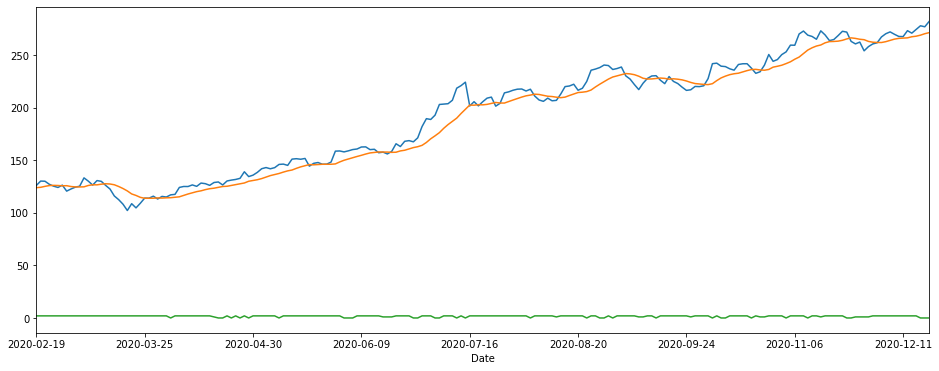

In [77]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['predictions'].plot(figsize=(16,6),x='Date', y='predictions')
#df['actual'].plot(figsize=(16,6),x='Date', y='actual')

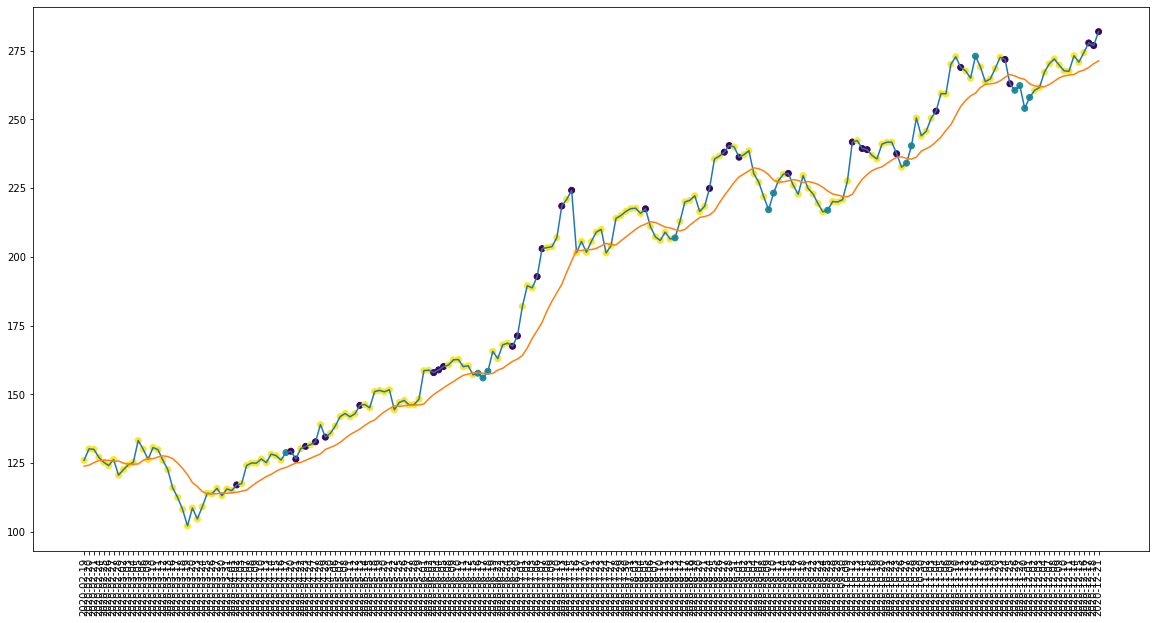

In [78]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

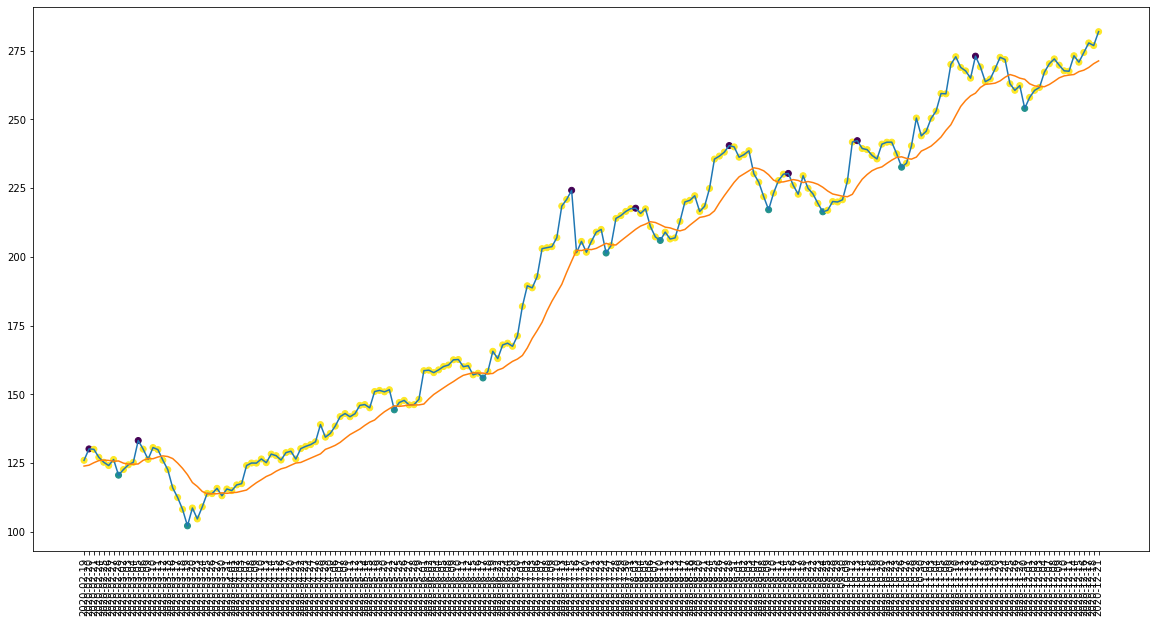

In [79]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [80]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 208
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 1
actual predicted sells: 3
actual sells but predicted hold: 4
actual holds but predicted buy: 11
actual holds but predicted sell: 30
actual predicted holds: 149
Percentage buys correct: 30.0%
Percentage sells correct: 37.5%
Percentage holds correct: 78.42105263157895%
actual buys: 10
actual sells: 8
actual holds: 190


In [81]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%") ; logger.append(str(100*correct_minima/buy) + "%") ; logger.append(str(100*correct_maxima/sell) + "%") ; logger.append(str(100*correct_hold/hold) + "%")

[120.5999984741211, 122.6500015258789, 124.0999984741211, 125.3000030517578, 126.0, 126.3000030517578, 127.0999984741211, 130.0, 130.14999389648438]
[120.5999984741211, 122.6500015258789, 124.37000274658205, 125.2699966430664, 126.3000030517578, 126.3499984741211, 130.07000732421878, 130.63999938964844, 133.19999694824222]
Percentage buys correct: 80.0%
Percentage sells correct: 45.45454545454545%
Percentage holds correct: 87.42138364779875%


In [82]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $128.80999755859378
Shares owned at the moment: 77
Cash capital at the moment: $54.35467100524693


Price increase from previously bought: 13.026656904824785%
Share price: $145.99000549316406
Shares owned at the moment: 0
Cash capital at the moment: $11264.671710315703


Share price: $157.67999267578125
Shares owned at the moment: 71
Cash capital at the moment: $38.605211765287095


Price increase from previously bought: 5.923830917897455%
Share price: $167.47999572753906
Shares owned at the moment: 0
Cash capital at the moment: $11896.984439254758


Share price: $206.8999938964844
Shares owned at the moment: 57
Cash capital at the moment: $71.25321311187327


Price increase from previously bought: 8.392115744889296%
Share price: $224.8800048828125
Shares owned at the moment: 0
Cash capital at the moment: $12854.163550666804


Share price: $217.1300048828125
Shares owned at the moment: 59
Cash capital at the moment: $8.26391928863086


Price increase from previously bought

In [83]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $22228.271841011046
profit gained: 122.28271841011048%


In [84]:
df_length = len(log)
log.loc[df_length] = logger
log.head()

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.734300,14.285714285714286%,30.0%,77.89473684210526%,52.38095238095238%,30.76923076923077%,83.01886792452831%,-5.942615165119223%,47.06870342285152%
1,0.721154,12.5%,12.5%,77.08333333333333%,50.0%,37.5%,85.09316770186335%,5.470774950237228%,66.69995791614528%
2,0.801932,12.5%,10.0%,86.77248677248677%,70.0%,43.75%,84.44444444444444%,4.182030078620865%,84.4058513034439%
3,0.745192,30.0%,37.5%,78.42105263157895%,80.0%,45.45454545454545%,87.42138364779875%,64.35121136344893%,122.28271841011048%


## Kweichow Moutai Co., Ltd. (Large Cap)

### Test Performance

#### Non-Recession

In [85]:
logger = []

In [86]:
seed = 10
df = pd.read_csv("data/variation 7/initial_indicators/600519.SS_data_test.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d      EMA_12   willr_14       OBV_7  labels
Date                                                              
2019-01-22   686.979980  640.790403 -10.183147  35030093.0     2.0
2019-01-23   671.000000  645.438034 -23.857615  30817872.0     2.0
2019-01-24   665.659973  648.549101 -28.427209  27455391.0     2.0
2019-01-25   672.500000  652.233855 -26.754575  30370918.0     2.0
2019-01-28   679.700012  656.459418 -19.452330  33269553.0     2.0


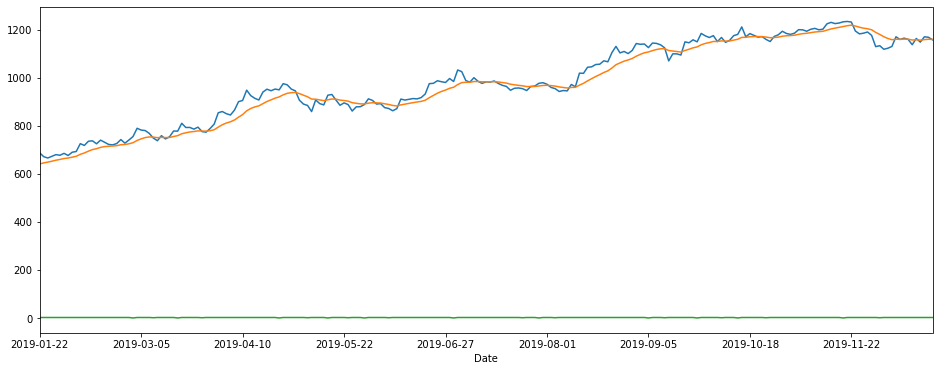

In [87]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [88]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [89]:
X = sequential
X  = np.array(X).reshape(-1, 15, 4)
y = labels
y = np.array(y)
X.shape

(207, 15, 4)

In [90]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [91]:
model = tf.keras.models.load_model("models/600779.SS_time_series_lstm_buy_hold_sell.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

7/7 [==============================] - 0s 3ms/step - loss: 0.2046 - accuracy: 0.7246 - mean_squared_error: 8.3515 - weighted_accuracy: 0.7246 - weighted_mean_squared_error: 8.3515
Test loss: 0.20459845662117004
Test accuracy: 0.7246376872062683


In [92]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({0: 30, 2: 162, 1: 15})

In [93]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [94]:
df = pd.read_csv("data/variation 7/initial_indicators/600519.SS_data_test.csv")
df.set_index('Date', inplace=True)

In [95]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-18,740.00000,704.389763,-23.444619,43919901.0,2.0,0,2
2019-02-19,730.76001,709.868261,-6.049880,47694490.0,2.0,0,2
2019-02-20,722.00000,713.082376,-17.677836,44744340.0,2.0,2,2
2019-02-21,720.25000,714.454318,-29.824573,40956103.0,2.0,2,2
2019-02-22,726.01001,715.345962,-32.098776,37971063.0,2.0,2,2


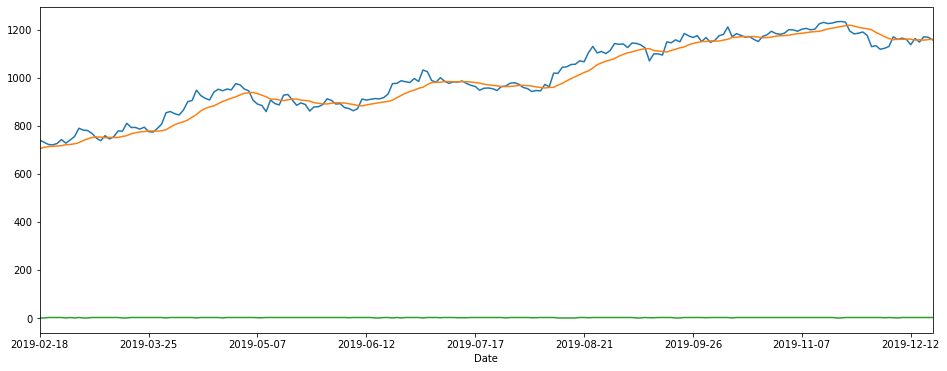

In [96]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['predictions'].plot(figsize=(16,6),x='Date', y='predictions')
#df['actual'].plot(figsize=(16,6),x='Date', y='actual')

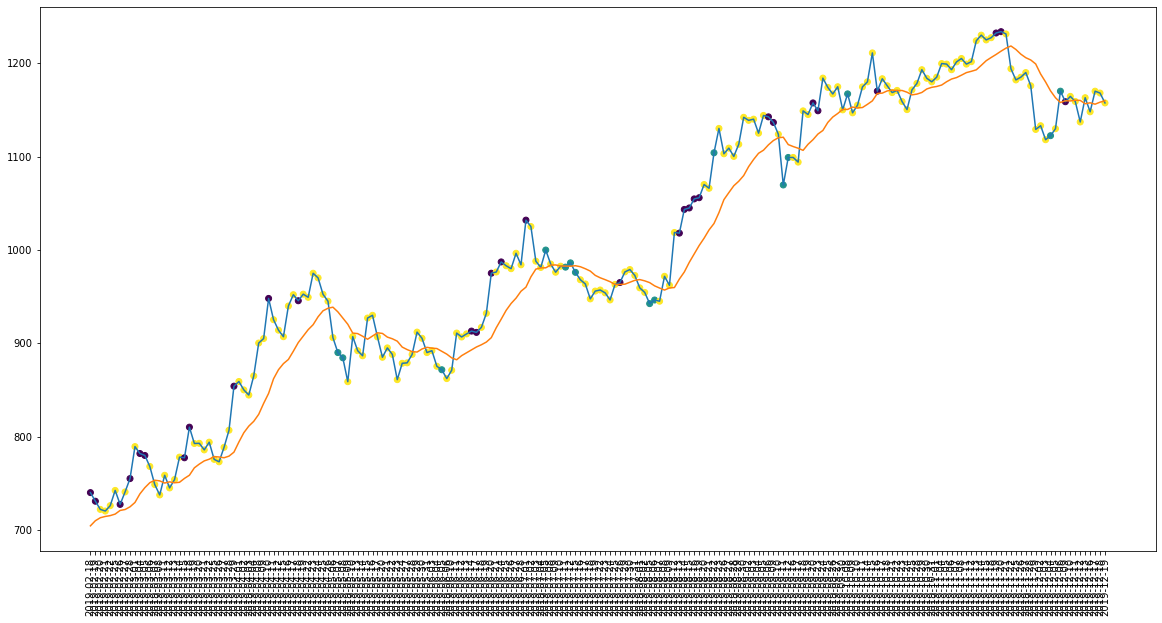

In [97]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

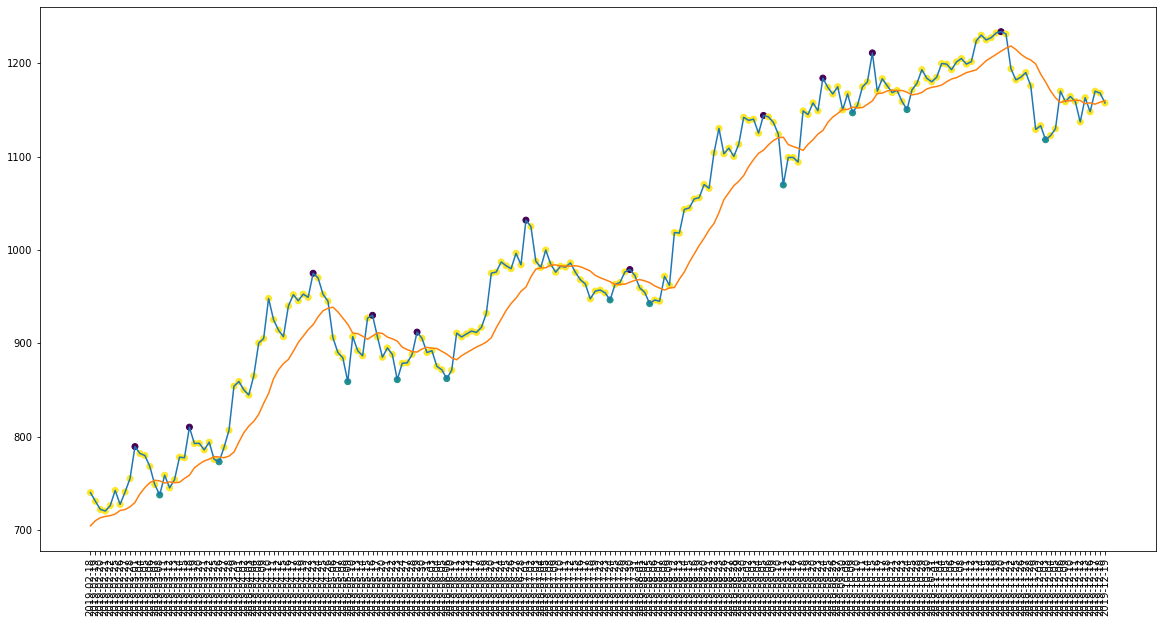

In [98]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [99]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 207
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 9
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 8
actual holds but predicted buy: 13
actual holds but predicted sell: 27
actual predicted holds: 145
Percentage buys correct: 18.181818181818183%
Percentage sells correct: 27.272727272727273%
Percentage holds correct: 78.37837837837837%
actual buys: 11
actual sells: 11
actual holds: 185


In [100]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%") ; logger.append(str(100*correct_minima/buy) + "%") ; logger.append(str(100*correct_maxima/sell) + "%") ; logger.append(str(100*correct_hold/hold) + "%")

[720.25, 722.0, 726.010009765625, 727.3499755859375, 730.760009765625, 740.0, 740.7000122070312, 742.3300170898438, 755.010009765625]
[727.3499755859375, 737.5, 740.7000122070312, 748.5999755859375, 755.010009765625, 768.0, 779.780029296875, 781.8599853515625, 789.2999877929688]
Percentage buys correct: 53.333333333333336%
Percentage sells correct: 50.0%
Percentage holds correct: 86.33540372670808%


In [101]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $890.0
Shares owned at the moment: 11
Cash capital at the moment: $183.07749999999942


Stop Loss Activated!

Share price: $858.8099975585938
Shares owned at the moment: 0
Cash capital at the moment: $9604.008470718383


Share price: $871.5999755859375
Shares owned at the moment: 10
Cash capital at the moment: $864.0397155303945


Price increase from previously bought: 11.556462878799923%
Share price: $975.0
Shares owned at the moment: 0
Cash capital at the moment: $10587.227215530394


Share price: $999.8200073242188
Shares owned at the moment: 10
Cash capital at the moment: $561.5320920867907


Stop Loss Activated!

Share price: $968.0
Shares owned at the moment: 0
Cash capital at the moment: $10214.91209208679


Share price: $942.4299926757812
Shares owned at the moment: 10
Cash capital at the moment: $764.6953405303939


Price increase from previously bought: 7.717107339297868%
Share price: $1017.9500122070312
Shares owned at the moment: 0
Cash capital at the moment: $

In [102]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $15358.36826651001
profit gained: 53.5836826651001%


In [103]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.734300,14.285714285714286%,30.0%,77.89473684210526%,52.38095238095238%,30.76923076923077%,83.01886792452831%,-5.942615165119223%,47.06870342285152%
1,0.721154,12.5%,12.5%,77.08333333333333%,50.0%,37.5%,85.09316770186335%,5.470774950237228%,66.69995791614528%
2,0.801932,12.5%,10.0%,86.77248677248677%,70.0%,43.75%,84.44444444444444%,4.182030078620865%,84.4058513034439%
3,0.745192,30.0%,37.5%,78.42105263157895%,80.0%,45.45454545454545%,87.42138364779875%,64.35121136344893%,122.28271841011048%
4,0.724638,18.181818181818183%,27.272727272727273%,78.37837837837837%,53.333333333333336%,50.0%,86.33540372670808%,21.036730481109554%,53.5836826651001%


### Recession

In [104]:
logger = []

In [105]:
seed = 10
df = pd.read_csv("data/variation 7/initial_indicators/600519.SS_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d       EMA_12   willr_14       OBV_7  labels
Date                                                               
2020-01-22  1075.300049  1097.577291 -89.711935   1200864.0     2.0
2020-01-23  1075.510010  1094.182325 -70.779503   4820868.0     2.0
2020-02-03  1052.800049  1087.815821 -81.895216   -525975.0     1.0
2020-02-04  1003.919983  1074.908769 -83.419991 -12870263.0     2.0
2020-02-05  1038.010010  1069.232037 -59.790669  -6607845.0     2.0


In [106]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [107]:
X = sequential
X  = np.array(X).reshape(-1, 15, 4)
y = labels
y = np.array(y)
X.shape

(208, 15, 4)

In [108]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [109]:
model = tf.keras.models.load_model("models/600779.SS_time_series_lstm_buy_hold_sell.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

7/7 [==============================] - 0s 4ms/step - loss: 0.2022 - accuracy: 0.6827 - mean_squared_error: 7.7352 - weighted_accuracy: 0.6827 - weighted_mean_squared_error: 7.7352
Test loss: 0.20224696397781372
Test accuracy: 0.682692289352417


In [110]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 153, 0: 40, 1: 15})

In [111]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [112]:
df = pd.read_csv("data/variation 7/initial_indicators/600519.SS_data_test2.csv")
df.set_index('Date', inplace=True)

In [113]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-19,1096.500000,1082.513705,-22.324305,-423291.0,2.0,2,2
2020-02-20,1118.000000,1084.665443,-12.988283,3281856.0,0.0,2,0
2020-02-21,1112.880005,1089.793836,-4.166667,7962118.0,2.0,0,2
2020-02-24,1087.180054,1093.345554,-10.201830,5068110.0,2.0,0,2
2020-02-25,1074.810059,1092.397016,-40.474836,1203074.0,2.0,2,2


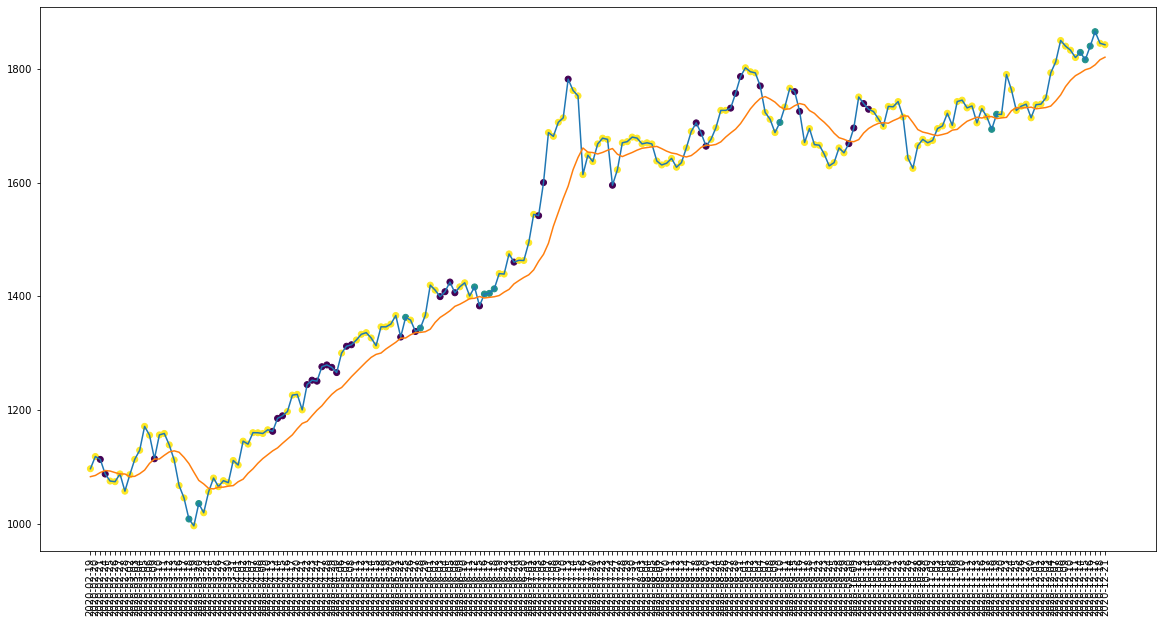

In [114]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

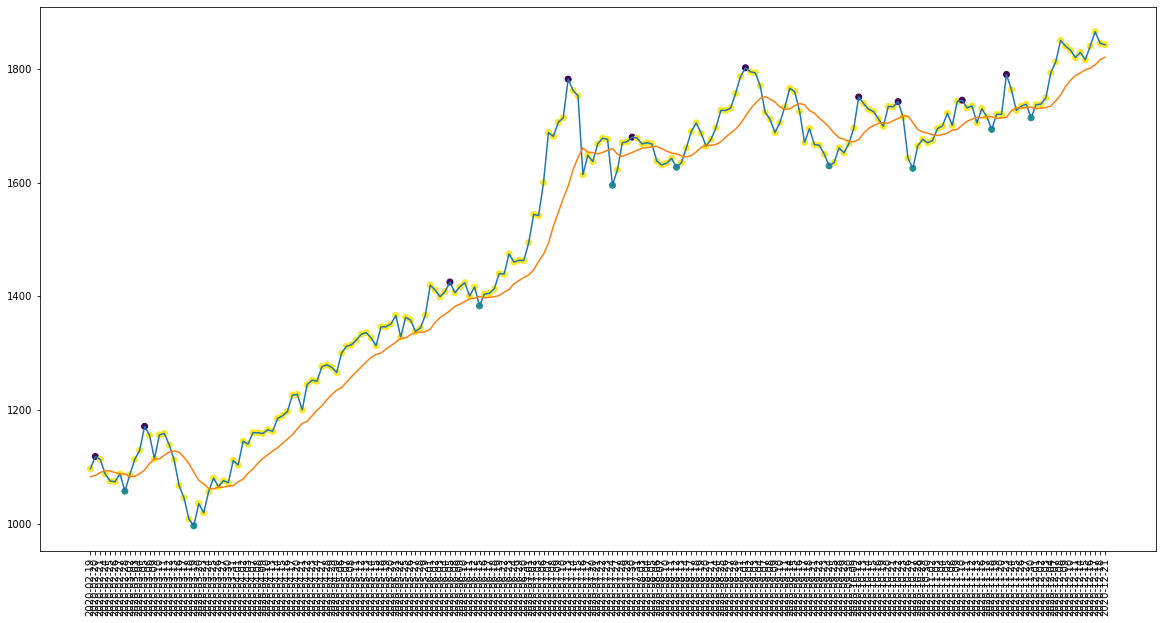

In [115]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [116]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 208
actual predicted buys: 1
actual buys but predicted sell: 2
actual buys but predicted hold: 6
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 8
actual holds but predicted buy: 14
actual holds but predicted sell: 36
actual predicted holds: 139
Percentage buys correct: 11.11111111111111%
Percentage sells correct: 20.0%
Percentage holds correct: 73.54497354497354%
actual buys: 9
actual sells: 10
actual holds: 189


In [117]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%") ; logger.append(str(100*correct_minima/buy) + "%") ; logger.append(str(100*correct_maxima/sell) + "%") ; logger.append(str(100*correct_hold/hold) + "%")

[1057.0, 1073.699951171875, 1074.81005859375, 1086.010009765625, 1087.1800537109377, 1087.3900146484377, 1096.5, 1112.8800048828123, 1118.0]
[1057.0, 1086.010009765625, 1087.3900146484377, 1113.0, 1114.010009765625, 1128.9200439453125, 1155.5, 1156.0, 1171.0]
Percentage buys correct: 66.66666666666667%
Percentage sells correct: 30.0%
Percentage holds correct: 85.52631578947368%


In [118]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $1007.989990234375
Shares owned at the moment: 9
Cash capital at the moment: $903.1423356323248


Price increase from previously bought: 14.992460313275103%
Share price: $1162.300048828125
Shares owned at the moment: 0
Cash capital at the moment: $11335.075848876953


Share price: $1362.9000244140625
Shares owned at the moment: 8
Cash capital at the moment: $401.89185302734404


Price increase from previously bought: 6.831459916515836%
Share price: $1460.010009765625
Shares owned at the moment: 0
Cash capital at the moment: $12049.8517109375


Share price: $1705.800048828125
Shares owned at the moment: 7
Cash capital at the moment: $76.41471820068364


Stop Loss Activated!

Share price: $1649.97998046875
Shares owned at the moment: 0
Cash capital at the moment: $11594.51246685791


Share price: $1693.6500244140625
Shares owned at the moment: 6
Cash capital at the moment: $1404.6670949707022




Capital at the end of test period: $12429.265844970701
profit gained: 24.292658

In [119]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $16641.259749999997
profit gained: 66.41259749999998%


In [120]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.734300,14.285714285714286%,30.0%,77.89473684210526%,52.38095238095238%,30.76923076923077%,83.01886792452831%,-5.942615165119223%,47.06870342285152%
1,0.721154,12.5%,12.5%,77.08333333333333%,50.0%,37.5%,85.09316770186335%,5.470774950237228%,66.69995791614528%
2,0.801932,12.5%,10.0%,86.77248677248677%,70.0%,43.75%,84.44444444444444%,4.182030078620865%,84.4058513034439%
3,0.745192,30.0%,37.5%,78.42105263157895%,80.0%,45.45454545454545%,87.42138364779875%,64.35121136344893%,122.28271841011048%
4,0.724638,18.181818181818183%,27.272727272727273%,78.37837837837837%,53.333333333333336%,50.0%,86.33540372670808%,21.036730481109554%,53.5836826651001%
5,0.682692,11.11111111111111%,20.0%,73.54497354497354%,66.66666666666667%,30.0%,85.52631578947368%,24.292658449707012%,66.41259749999998%


In [121]:
experiment

'Variation 7 LSTM Experiments results - 600779.SS'

In [122]:
log.to_csv('{}.csv'.format(experiment))